# Neural Scattering Fields Demo (In Progress)
In this notebook, we use our `lego-mist` scene to demonstrate our multiple-scattering NeRF.\
(later, the model will be able to run on the command line using `python3 run_nerf.py <path to data> <output path> <environment map path>`)

## Data
First, we start by fetching and processing the data (images and poses).\
**NOTE:** utils.load_transforms_json only handles instant-NGP-like json formatting.\
Hence, this will not work out the box with synthetic-NeRF datasets.\
(Take a look at `data/lego_mist/transforms_train.json` file for an example.)

In [437]:
# autoreload imports for dev
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [438]:
import os
import utils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# get train and test data
train_dict  = utils.load_transforms_json(os.path.join(os.getcwd(), "data", "lego_mist"), "transforms_train.json")
test_dict   = utils.load_transforms_json(os.path.join(os.getcwd(), "data", "lego_mist"), "transforms_test.json")
train_imgs  = utils.get_images_from_folder(os.path.join(os.getcwd(), "data", "lego_mist", "train"))
env_map     = np.array(Image.open("env_map_example.png"))[..., :3]

perform_downsampling = True
# Our datasets do not have test_imgs for evaluation.
# Therefore, as a temporary measure, we extract a few images from the training set as test instances.
# Hence, it will be used only to demonstrate novel view synthesis.
# test_imgs   = utils.get_images_from_folder(os.path.join(os.getcwd(), "data", "lego_mist", "test"))

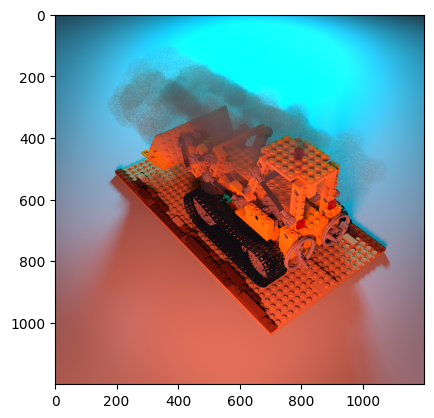

In [439]:

# Also, NeRF is expensive, and multi-scattering NeRF is a order of magnitude higher than that!
# Here, we choose to downsample our images to reduce the computational load.
from utils import downsample

train_imgs_ds = downsample(train_imgs, scaling_factor=12) # (100, 100, 3)
plt.imshow(train_imgs_ds[0])

if perform_downsampling:
    train_imgs = train_imgs_ds

## Camera Pose Visualization
As a sanity check, we can visualize the camera positions and their viewing directions.\
Here, it looks good; all cameras are looking inward towards our scene object.\
We can also visualize our expected test poses: a circular orbit around the scene on the xy plane.

Train poses:


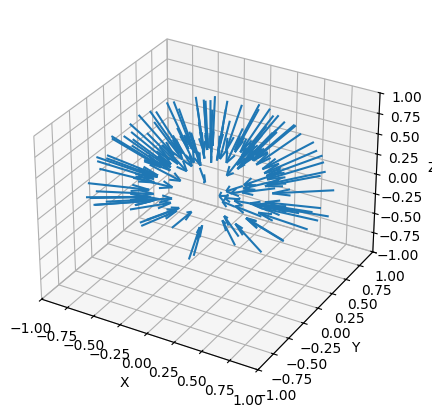

Test poses:


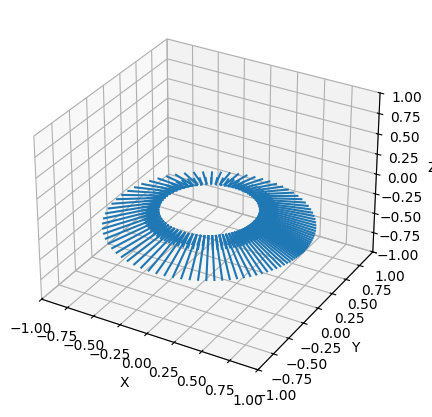

In [440]:
from render import get_camera_poses, get_camera_poses_normalized
import ms_nerf as ms
import torch

train_poses = train_dict["poses"]
test_poses  = test_dict["poses"]
focal_x, focal_y = train_dict["focal"][:]
N_train = train_poses.shape[0]
N_test  = test_poses.shape[0]
H, W = train_imgs[0].shape[:2]
print("Train poses:")
train_origins_raw, _ = get_camera_poses(train_poses, transpose=False, normalize=False)
utils.ray_plot_scaled(*get_camera_poses(train_poses, transpose=False, normalize=True))
scene_center = train_origins_raw.mean(dim=0, keepdim=True)  # shape (1,3)
scale = torch.max(torch.norm(train_origins_raw - scene_center, dim=-1))
print("Test poses:")
utils.ray_plot_scaled(*get_camera_poses_normalized(test_poses, transpose=False, normalize=True, is_test=True, center=scene_center, scale=scale))

## Ray Tracing
Just as a ray tracer does, we shoot a ray through each "pixel" of the virtual image plane.\
This is covered by `get_rays`. Sampling along the ray via volumetric rendering is found in `sample_hierarchical`, made up of two passes as in vanilla NeRF:
- coarse pass (`sample_rays`)
- fine pass (`sample_fine`)

For more information, check out `render.py`.

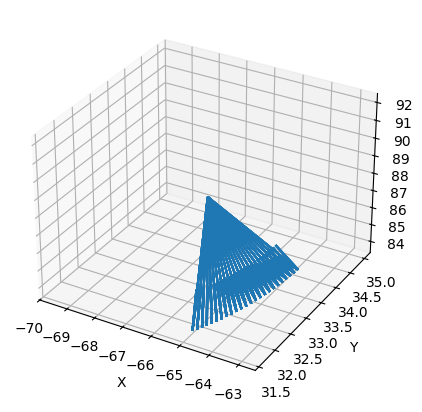

In [441]:
from render import get_rays

## an example of get_rays output ##
with torch.no_grad():
    rays_o, rays_d = get_rays(train_poses, H, W, focal_x, focal_y, batched=True)
    utils.ray_plot(rays_o.reshape(-1, 3)[0:10000:50, :], rays_d.reshape(-1, 3)[0:10000:50, :])



#### Phase function sampling: Henyey-Greenstein (single-scattering) vs Uniform Sampling (multi-scattering)
In multi-scattering NeRF, we add scattering capabilities. This can be done by randomly sampling from a phase function\
per coarse and fine sample positions given by `sample_hierarchical`.

This is what we use to sample rays in single-scattering.\
**NOTE:** Sampling using `sample_next_directions` is relative to the ray coordinate frame.\
These need to be transformed into the world frame by using `local_to_world_rotation`.

[PDF] 0.999 aligned at g=0.99:	 306.29254744445024
[PDF] 0.999 aligned at g=0.9999: 5.585174430227958


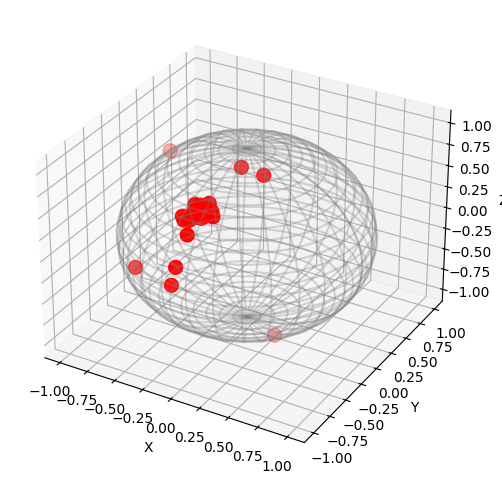

In [511]:
## HG demo ##
from render import henyey_greenstein_pdf, sample_henyey_greenstein
from sh import visualize_spherical_samples
from utils import local_to_world_rotation, spherical_to_cartesian, cartesian_to_spherical


# generate samples; play with 'g' and see how sampling densities change throughout the spherical area
# also, change 'ray_dir' to update the position in world coordinates (NOTE: +z in the plot is upward, unlike our volume renderer) 
num_rays_to_shoot = 128
ray_dir = torch.tensor([0,-1,1], dtype=torch.float32)  # w.r.t world
g = 0.99

# local to world position
R = local_to_world_rotation(ray_dir.reshape(-1,3))

# NOTE: lots of discrepancy between 0.99 and 0.9999. The sensitivity to change is highly non-linear
# (could this impact training? Maybe there's a transformation that can make this behave better. TODO)
# additonally, if you check the henyey_greenstein_pdf, you can see that if g ~= 1, then even the smallest offset
# of cos_theta can go from extremely high probability density to very low ones.
print("[PDF] 0.999 aligned at g=0.99:\t", henyey_greenstein_pdf(1 - 1e-4, g=0.99))
print("[PDF] 0.999 aligned at g=0.9999:", henyey_greenstein_pdf(1 - 1e-4, g=0.9999))


theta_phi = sample_henyey_greenstein(*torch.rand(2, num_rays_to_shoot), g=g) # w.r.t the current ray direction
local_dirs = spherical_to_cartesian(theta_phi) # (num_samples, 3)
world_dirs = torch.einsum("bij,kj->bki", R, local_dirs)
theta_phi = cartesian_to_spherical(world_dirs.squeeze(0))
visualize_spherical_samples(*theta_phi.T)

Below is the same visualization, but using an **isotropic phase function**, which is equivalent to g=0.\
This is used in multiple scattering using the learned SH coefficients from the SH network.

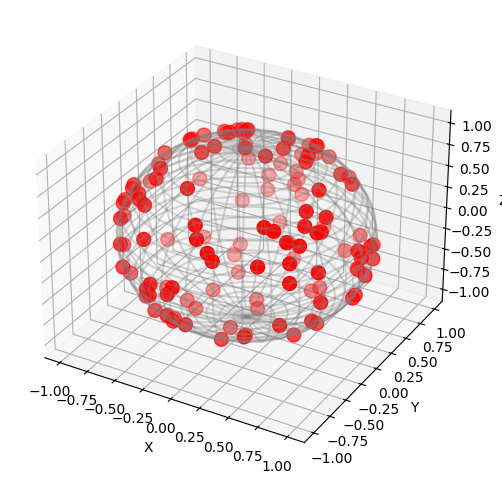

In [502]:
## Uniform Demo ##
from sh import visualize_spherical_samples
from render import sample_isotropic
# because uniform/isotropic distribution, we can forego ray to world frame transformations
# since all directions are equally likely

theta_phi2 = sample_isotropic(*torch.rand(2, num_rays_to_shoot))
visualize_spherical_samples(*theta_phi2.T)

### Radiance Evaluation

We use **spherical harmonics** to approximate multi-scattering contributions per sample.\
Specifically, we call `eval_sh` to get the radiance using Legendre polynomials and our learned coefficients.

We also directly sample the environment map using `eval_env_map` using sampled directions\
from `sample_isotropic`.

Examples of each are shown below.

This is our original environment map:



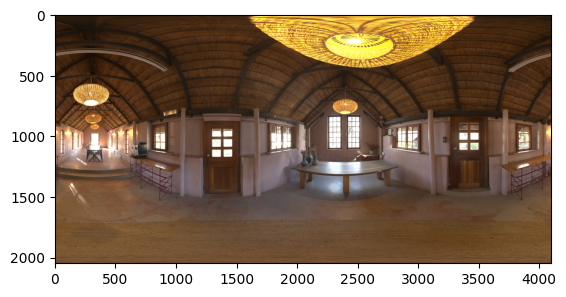

In [450]:
from render import eval_env_map, isotropic_pdf
from sh import project_to_sh, reconstruct_sh_image, plot_sh_texture

print("This is our original environment map:\n")
plt.imshow(env_map)


This is what happens when we transform it into frequency domain using SH:



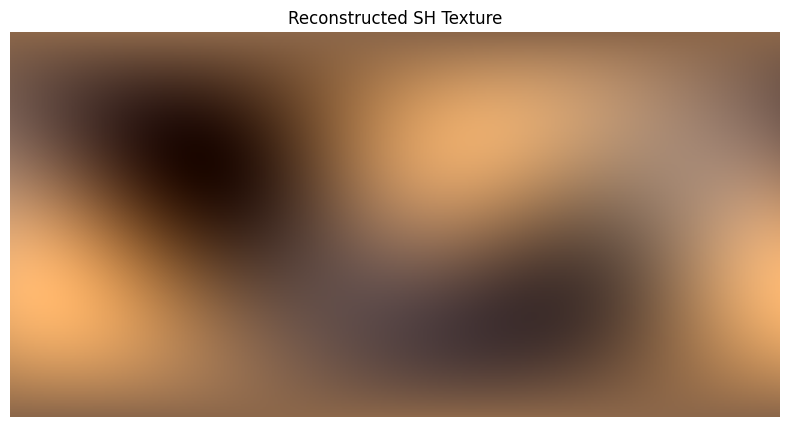

In [367]:
## Demo of spherical harmonic lighting used for multiple scattering ##
# in the model, these coefficients will be learned from the network (SphericalHarmonicMLP)
print("This is what happens when we transform it into frequency domain using SH:\n")
env_map_sh_coefs = project_to_sh(torch.tensor(env_map), phase_function=sample_isotropic, sample_pdf=isotropic_pdf, lmax=2, num_samples=64)
plot_sh_texture(reconstruct_sh_image(env_map_sh_coefs, lmax=2))

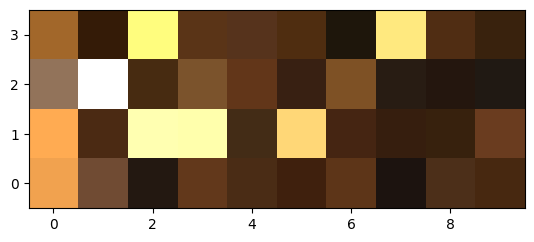

In [454]:
## Demo of single scattering sampling the environment map given 3D directional vectors ##
# in the model, instead of random directions, these will be sampled from the HG phase function
plt.imshow(eval_env_map(torch.rand(4,10,3), torch.tensor(np.array(Image.open("env_map_example.png")))[...,:3]), origin="lower")

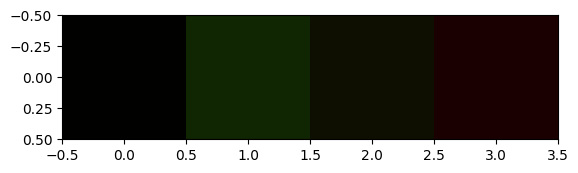

In [455]:
## Demo of multi-scatter sampling SH lighting ##
# this may look non-sensical right now; that is to be expected for random values
# in practice, our model will learn these to capture radiance that makes more sense for the environment lighting
from render import eval_sh

plt.imshow(torch.mean(eval_sh(torch.rand(4,3,9), torch.rand(4,64,3), lmax=2, spherical=False), dim=-2).unsqueeze(0))

## Network
After this, we set up our component modules for our `NeuralScatteringField`, defined in `ms_nerf.py`.

### Positional Encoder
Just like NeRF, we use a fixed sinusoid-based PE to enable the capture of high-fidelity details.

In [456]:
from ms_nerf import PositionalEncoder

x_encoder = PositionalEncoder(3, 8, include_input=True, device="cpu") # change to 'cuda' when working for real
d_encoder = PositionalEncoder(3, 1, include_input=True, device="cpu") # change to 'cuda' when working for real

# to prevent crashing due to memory constraints, we take 3 tensors:
with torch.no_grad():
    first3_rays_o = rays_o.reshape(-1, 3)[:3, :]
    first3_rays_d = rays_d.reshape(-1, 3)[:3, :]
    x_enc = x_encoder(first3_rays_o)
    d_enc = d_encoder(first3_rays_d)
print(x_enc.shape, d_enc.shape) # here, we should get (3, 51) and (3, 9) respectively

torch.Size([3, 51]) torch.Size([3, 9])


### Intemediate Networks  
An overview of what input data is expected from the networks, and what outputs they should have:

In [ ]:
## Demo of untrained component MLPs ##
from ms_nerf import FeatureMLP, ScatterMLP, SphericalHarmonicsMLP, VisibilityMLP
from render import sample_next_directions

with torch.no_grad():
    # Feature network
    fmlp = FeatureMLP(x_encoder.output_dim)
    fmlp_output = fmlp(x_enc)
    print("Feature MLP output shape: ", fmlp_output.shape) # should be [NHW=3, 256]

    # Scatter network (note: sigma_s is per channel [3-dim])
    scmlp = ScatterMLP(fmlp.output_dim)
    scmlp_output = scmlp(fmlp_output)
    print("Scatter MLP output: ", scmlp_output.shape) # should be [NHW=3, sigma_{t,s},g=5]
    # notice 'g' values should be [-1, 1]
    print(scmlp_output[..., 4])

    # SH network
    shmlp = SphericalHarmonicsMLP(fmlp.output_dim, lmax=2)
    shmlp_output = shmlp(fmlp_output)
    print("SH MLP output shape: ", shmlp_output.shape) # should be [NHW=3, rgb=3, #coefs for lmax2=9]

    # Visibility network
    # NOTE: internally, we do not actually use d_encoder on rays_d like in NeRF
    # instead, we sample (64 times) from 'sample_next_directions' per sample along the ray and encode those!

    # code extracted (slightly edited) directly from 'volume_render':
    bounce_dirs = sample_next_directions(
        torch.rand(3, 3), lambda u,v: sample_henyey_greenstein(u,v,g=g), num_samples=64)
    print(bounce_dirs.shape)

    # ENCODE bounce_dirs
    bounce_dirs_enc = d_encoder(bounce_dirs.reshape(-1, bounce_dirs.shape[-1]))
    print(bounce_dirs_enc.shape)

    # "query: at this point and direction, what's my T?"
    vmlp = VisibilityMLP(x_encoder.output_dim, d_encoder.output_dim)
    vmlp_output = vmlp(x_enc.unsqueeze(1).expand(-1, 64, -1).reshape(-1, x_enc.shape[-1]), bounce_dirs_enc)
    print("Visibility MLP output shape: ", vmlp_output.shape) # should be [NHWS=3*64, bounce_dirs=64, transmittance=1]
    # when using, can reshape back to [3, 64, 1]

Feature MLP output shape:  torch.Size([3, 256])
Scatter MLP output:  torch.Size([3, 5])
tensor([-0.0484, -0.0484, -0.0484])
SH MLP output shape:  torch.Size([3, 3, 9])
torch.Size([3, 64, 3])
torch.Size([192, 9])
Visibility MLP output shape:  torch.Size([192, 1])


## Rendering (scattering)
For this ***important*** part of the model, take a look in `render.py` for the `volume_rendering` function and adjacent parts like `multi_scatter`, `single_scatter`, and `nerf_forward`.\
There are lots of comments that describe the algortihm in those functions.

However, we also test them right here. (And, as before, we only evaluate a few rays due to memory constraints.)


### Single Scattering

In [458]:
from render import single_scatter, multi_scatter, volume_render, nerf_forward

## Single Scattering -- MC to approximate radiance from single-bounce contribution
# we assume a random sigma_s here
with torch.no_grad():
    some_dirs = torch.rand(3,3).unsqueeze(1).expand(-1, 64, -1) # lift to (3,64,3)
    sigma_s = torch.rand(1,3)

    L_s = single_scatter(
        env_map, some_dirs, bounce_dirs, vmlp_output, sigma_s=sigma_s, g=0.0
    ) # these values are the monte carlo radiance estimates per sample S per H*W ray
    # transmittance is applied from vmlp_output
print(L_s.shape) # (NHWS, rgb=3)
print(L_s.detach())
# the printed values are mock outputs we can expect to get
# in volume_render, these L_s values are clamped to [0, 255] or normalized [0,1]

torch.Size([3, 3])
tensor([[173.1213,   1.3256,  72.9336],
        [208.3344,   1.9442, 192.1194],
        [107.8899,   0.8935,  67.7626]])


### Multi-Scattering

In [459]:
## Multi-scattering -- MC across 64 samples (internal, inside a call to eval_sh)
L_m = multi_scatter(shmlp_output, sigma_s, rays_d.reshape(-1,3)[0:3], num_samples=64)
print(L_m.shape) # (NHWS, rgb=3)
print(L_m)

torch.Size([3, 3])
tensor([[0.0268, 0.0007, 0.0406],
        [0.0268, 0.0007, 0.0406],
        [0.0267, 0.0007, 0.0407]])


## Training
Here, we borrow training metadata from the *Neural Relightable Participating Media Rendering* (Zheng et al.) paper.\
At the current time of construction, our model is pretty much the same as theirs, except ours is more constrained in only allowing environment map lighting.\
We train the model for 200K iterations, with a batch of 1200 primary rays each batch.\
We also decay the learning rate from $1\times 10^{-4}\to 1\times 10^{-5}$.

### Config/Hyperparameters

In [488]:
## hyperparameter config ##

num_samples_per_ray = 64
perturb = True  # for stratified sampling along the ray (instead of quadrature)
num_samples_hierarchical = 64
perturb_hierarchical = False
inverse_depth = False

# Optimizer
lr = 1e-4  # Learning rate

# Training
n_iters = 200_000
one_image_per_step = True   # One image per gradient step (disables batching)
# chunk_size = 2**14          # Modify as needed to fit in GPU memory
chunk_size = 1200          # Modify as needed to fit in GPU memory
display_rate = 25           # Display test output every X epochs

# Early Stopping
warmup_iters = 100          # Number of iterations during warmup phase
warmup_min_fitness = 10.0   # Min val PSNR to continue training at warmup_iters
n_restarts = 10             # Number of times to restart if training stalls

# bundle the kwargs for various functions to pass in all at once
kwargs_sample_stratified = {
    'num_samples': num_samples_per_ray,
    'perturb': perturb,
    'inverse_depth': inverse_depth
}

kwargs_sample_hierarchical = {
    'perturb': perturb_hierarchical,
    'num_samples': num_samples_hierarchical,
}

In [489]:
# including early stopping and a learning rate scheduler
from torch.optim.lr_scheduler import LinearLR

class EarlyStopping:
    """Early stopping helper based on fitness criterion."""
    def __init__(
        self,
        patience: int = 30,
        margin: float = 1e-4
    ):
        self.best_fitness = 0.0  # In our case PSNR
        self.best_iter = 0
        self.margin = margin
        self.patience = patience or float('inf')  # epochs to wait after fitness stops improving to stop

    def __call__(
        self,
        iter: int,
        fitness: float
    ):
        """Check if criterion for stopping is met."""
        if (fitness - self.best_fitness) > self.margin:
            self.best_iter = iter
            self.best_fitness = fitness
        delta = iter - self.best_iter
        stop = delta >= self.patience  # stop training if patience exceeded
        return stop
  

def init_scheduler(optimizer, total_epochs=n_iters):
    return LinearLR(optimizer, 
            start_factor=1.0, # this'll be 1e-4
            end_factor=0.1,   # * 0.1 = 1e-5
            total_iters=total_epochs)


In [514]:
from ms_nerf import create_default_network_component_dict
mock_rays_o = rays_o[0][:100, :100]
mock_rays_d = rays_d[0][:100, :100]

print(mock_rays_o.shape)
print(mock_rays_d.shape)

coarse_net = create_default_network_component_dict()
fine_net = coarse_net   # network instances should be SHARED

# NOTE: current progress is up to here; nerf_forward needs to be debugged

nerf_forward(
    mock_rays_o,
    mock_rays_d,
    near=2, far=90,
    encoding_fn=x_encoder, 
    viewdirs_encoding_fn=d_encoder,
    env_map=env_map,
    coarse_nets=coarse_net,
    fine_nets=fine_net,
    kwargs_sample_stratified=kwargs_sample_stratified,
    kwargs_sample_hierarchical=kwargs_sample_hierarchical,
    chunk_size=chunk_size
)

torch.Size([100, 100, 3])
torch.Size([100, 100, 3])


RuntimeError: einsum(): the number of subscripts in the equation (2) does not match the number of dimensions (3) for operand 1 and no ellipsis was given

In [ ]:
# TODO: call training loop
def train():
    pass

## Testing
Here, we render the scene using test poses unseen during training.

In [ ]:
# TODO: choose some random test poses and render their views